# Environments

In [1]:
import tensorflow as tf
import numpy as np
import math
import timeit
import matplotlib.pyplot as plt
from __future__ import print_function

import os.path
import sys
import time

import urllib

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'

In [2]:

"""
Please note, the environments for the codes.
"""

import platform

print(platform.linux_distribution())

print(platform.python_version())

print(tf.__version__)

print(np.__version__)

('Ubuntu', '14.04', 'trusty')
2.7.6
1.0.1
1.13.1


# Load Data

In [2]:
"""
references:  stanford cs231n assignment2
"""

from cs231n.data_utils import load_CIFAR10

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=10000):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the two-layer neural net classifier. These are the same steps as
    we used for the SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

    # Subsample the data
    mask = range(num_training, num_training + num_validation)
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = range(num_training)
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = range(num_test)
    X_test = X_test[mask]
    y_test = y_test[mask]

    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis=0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image

    return X_train, y_train, X_val, y_val, X_test, y_test


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()
print('Train data shape:         ', X_train.shape)
print('Train labels shape:       ', y_train.shape)
print('Validation data shape:    ', X_val.shape)
print('Validation labels shape:  ', y_val.shape)
print('Test data shape:          ', X_test.shape)
print('Test labels shape:        ', y_test.shape)
print('X_train.dtype:            ', X_train.dtype)
print('y_train.dtype:            ', y_train.dtype)

Train data shape:          (49000, 32, 32, 3)
Train labels shape:        (49000,)
Validation data shape:     (1000, 32, 32, 3)
Validation labels shape:   (1000,)
Test data shape:           (10000, 32, 32, 3)
Test labels shape:         (10000,)
X_train.dtype:             float64
y_train.dtype:             int64


# Visualize Examples

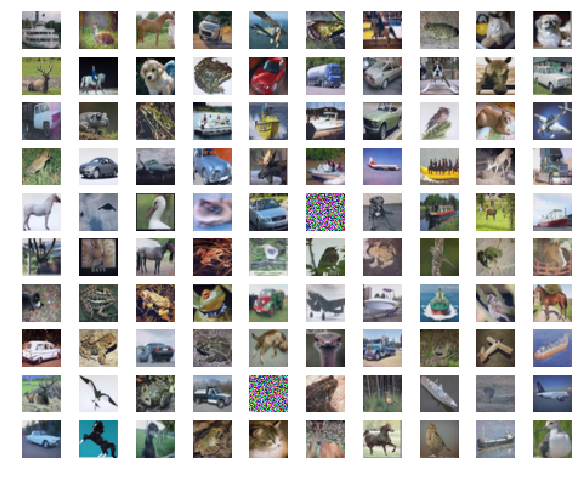

In [4]:
img = X_train[np.random.randint(0, 49000, size = 100), :]
img_max, img_min = np.max(img), np.min(img)
img = 255.0 * (img - img_min) / (img_max - img_min)
img = img.astype('uint8')

    
for i in range(10):
    for j in range(10):
        plt.subplot(10, 10, i * 10 + j + 1)
        plt.imshow(img[i * 10 + j, :])
        plt.gca().axis('off')
        
plt.show()

# Model

In [24]:
def weight_variable_reg(shape, stddev, reg):
    var = tf.Variable(tf.truncated_normal(shape, stddev = stddev))
    if reg is not None:
        weight_loss = tf.multiply(tf.nn.l2_loss(var), reg, name = 'weight_loss')
        tf.add_to_collection('losses', weight_loss)
    return var


def model(X, hidden_size, stddev, reg):
    """
    conv - RELU - POOL - FC - RELU - SOFTMAX
    
    """
    shape = [3, 3, 3, 64]
    Wconv = weight_variable_reg(shape, stddev, reg)
    bconv = tf.Variable(tf.zeros([64]))
    
    a = tf.nn.conv2d(X, Wconv, strides=[1, 1, 1, 1], padding='SAME') + bconv
    h = tf.nn.relu(a)
    
    h_pool = tf.nn.max_pool(h, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    
    a_fc = tf.reshape(h_pool, [-1, 16 * 16 * 64])  
    shape = [16 * 16 * 64, hidden_size]
    
    W1 = weight_variable_reg(shape, stddev, reg)
    b1   = tf.Variable(tf.zeros([hidden_size]))    
    h1_fc = tf.matmul(a_fc, W1) + b1
    h1_relu = tf.nn.relu(h1_fc)
    
    W2 = weight_variable_reg([hidden_size, 10], stddev, reg)
    b2 = tf.Variable(tf.zeros([10]))
        
    y_out = tf.matmul(h1_relu, W2) + b2

        
    return y_out
               

def model_loss(logits, y):
    """
    Args:
        logits: Logits tensor, float -[batch_size, NUM_CLASSES]
        y     : Labels tensor, int64 -[batch_size],   NOT ONE HOT
        
    Returns:
        loss: Loss tensor of type float    
    """
    
    y = tf.to_int64(y)
    
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    mean_loss = tf.reduce_mean(loss)
    
    return mean_loss  


def training(loss, update_rule, initial_learining_rate, learning_rate_decay, decay_steps):
    """
    Sets up the training Ops.
 
    Args:
        loss:          Loss tensor.
        learning_rate: The learning rate to use for gradient descent.
    Returns:
        train_op: The Op for training.
    """
    
    global_step = tf.Variable(0, name = 'global_step', trainable = False)
    
    learning_rate = tf.train.exponential_decay(initial_learining_rate, 
                                               global_step, decay_steps, learning_rate_decay, staircase=True)
    
    if update_rule is 'sgd':
        optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    elif update_rule is 'sgd_momentum':
        optimizer = tf.train.MomentumOptimizer(learning_rate, momentum=0.9)
    elif update_rule is 'adam':
        optimizer = tf.train.AdamOptimizer(learning_rate)
    else:
        raise ValueError('Invalid update_rule "%s"' % update_rule)
      
    
    train_op = optimizer.minimize(loss, global_step = global_step)
    
    return train_op


def check_accuracy(sess, X_data, y_data, X, y, target, num_samples=None, batch_size=100):
    
    N = X_data.shape[0]
    if num_samples is not None and N > num_samples:
        mask = np.random.choice(N, num_samples)
        N    = num_samples
        X_data = X_data[mask]
        y_data = y_data[mask]
        
    num_batches = np.ceil(1.0 * N / batch_size)
    acc = 0.0
    for i in xrange(num_batches.astype('int32')):
        start = i * batch_size
        end   = min(N, (i + 1) * batch_size)
        feed_dict = {X: X_data[start : end], y: y_data[start : end]}
        _acc = sess.run(target, feed_dict=feed_dict)
        acc += _acc
        
    return 1.0 * acc / N



def evaluation(logits, labels):
    """
    Args:
        logits: Logits tensor, float - [batch_size, NUM_CLASSES]
        labels: labels tensor, int32 - [batch_size], in the range [0, NUM_CLASSES)
    
    Returns:
        A scalar int32 tensor
   
    """
    
    correct = tf.equal(tf.argmax(logits, axis=1), labels)

    
    return tf.reduce_mean(tf.cast(correct, tf.float32))   



def num_correct_pred(logits, labels):
    """
    Args:
        logits: Logits tensor, float - [batch_size, NUM_CLASSES]
        labels: labels tensor, int32 - [batch_size], in the range [0, NUM_CLASSES)
    
    Returns:
        A scalar int32 tensor
   
    """
    
    correct = tf.equal(tf.argmax(logits, axis=1), labels)
    
    return tf.reduce_sum(tf.cast(correct, tf.float32))                  

# Graph

In [25]:
def placeholder_inputs(batch_size):
    """
    A function to generate placeholder variables for the input tensors
    
    Args:
        batch_size
        
    Returns:
        images_placeholder:  input image placeholder
        labels_placeholder:  input image labels placeholder   
        is_training       :  training or validing
    """
    
    X = tf.placeholder(tf.float32, shape=[batch_size, 32, 32, 3])
    y = tf.placeholder(tf.int64, shape=[batch_size])

    return X, y

    
def data_next_batch(indicies, data_set, label_set, i):
    """
    Args:
        indicies:  The shuffled indexes of training data_set 
        data_set:  images from cifar10  
        label_set: labels from cifar10
        i        : the ith batch data
        
    Returns:
        images and labels for feed_dict
       
    """
    start_idx = (i * configs.batch_size) % data_set.shape[0]
    end_idx = np.min([start_idx + configs.batch_size, data_set.shape[0]])
    
    idx = indicies[start_idx : end_idx]
    
    
    return data_set[idx, :], label_set[idx]
 
def get_session():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    session = tf.Session(config=config)
    return session 
    
def run_training(configs, visualization = False):
    """Train MNIST for a number of steps."""
    # Get the sets of images and labels for training, validation, and
    # test on MNIST.
    
    # Tell TensorFlow that the model will be built into the default Graph.
    with tf.Graph().as_default():
        X, y, = placeholder_inputs(None)
      
        y_out = model(X, configs.hidden_size, configs.stddev, configs.reg)
                
        accuracy = evaluation(y_out, y)
        
        correct_num = num_correct_pred(y_out, y)   ## for test set, batch calculating
        
        loss = model_loss(y_out, y) + tf.get_collection('losses')
        
        extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
        with tf.control_dependencies(extra_update_ops):        
            train_step = training(loss, configs.update_rule, configs.initial_learining_rate, 
                             configs.learning_rate_decay, configs.decay_steps)
          
        
        saver = tf.train.Saver()

        init = tf.global_variables_initializer()
        
        sess = get_session()
        sess.run(init)
        
        iter_cnt = 1
        best_val_acc = -1
        losses = []
        train_accuracies = []            
        for e in range(configs.epochs):
            validing_now = False

            train_indicies = np.arange(X_train.shape[0])
            np.random.shuffle(train_indicies)
 
            for i in range(int(math.ceil(X_train.shape[0] * 1.0 / configs.batch_size))):
        
                    
                batch_X, batch_y = data_next_batch(train_indicies, X_train, y_train, i)    


                if i % configs.print_every == 0 and (visualization or configs.verbose):
                    feed_dict = {X: batch_X, y: batch_y}
                    train_accuracy = sess.run(accuracy, feed_dict = feed_dict)
                    if configs.verbose is True:
                        print('Iter %9d, training batch accuracy %g' % (iter_cnt, train_accuracy))
                    train_accuracies.append(train_accuracy)
                    
                                        
                feed_dict = {X: batch_X, y: batch_y}
                _loss, _ = sess.run([loss, train_step], feed_dict= feed_dict)
                losses.append(_loss)
                                
                iter_cnt += 1
                
                
                
            validing_now = True 
            
            if validing_now:
                feed_val_dict = {X: X_val, y: y_val} 
                val_loss, val_acc = sess.run([loss, accuracy], feed_dict = feed_val_dict)
 
                if val_acc > best_val_acc:
                    best_val_acc = val_acc
                    saver.save(sess, configs.model_path_name)                             
                

            print("Epoch {2}, Overall validation loss = {0}, \n validation acuracy = {1}".format(val_loss, val_acc, e+1))
            print("Epoch {1}, best validation accuracy = {0}".format(best_val_acc, e+1))
                                                      
        ## visualizing loss and accuracy 
        if visualization:
            plt.subplot(2, 1, 1)
            plt.plot(losses)
            plt.grid(True)
            plt.title('Training Loss')
            plt.xlabel('minibatch number')
            plt.ylabel('minibatch loss')

            plt.subplot(2, 1, 2)
            plt.plot(train_accuracies)
            plt.title("Training accuruacy")
            plt.xlabel("look_every number")
            plt.ylabel("correct accuracy")


            plt.show()    
        
    ## load the best model
    saver.restore(sess, configs.model_path_name)
       
    test_acc = check_accuracy(sess, X_test, y_test, X, y, correct_num, num_samples=None, batch_size=100)
           
    print("best_val_acc: %f  , test set accuracy: %f  " % (best_val_acc, test_acc))
    
    return best_val_acc, test_acc
    




# Training

Iter         1, training batch accuracy 0.166667
Iter        51, training batch accuracy 0.3125
Iter       101, training batch accuracy 0.40625
Iter       151, training batch accuracy 0.416667
Iter       201, training batch accuracy 0.4375
Iter       251, training batch accuracy 0.40625
Iter       301, training batch accuracy 0.5
Iter       351, training batch accuracy 0.583333
Iter       401, training batch accuracy 0.520833
Iter       451, training batch accuracy 0.489583
Iter       501, training batch accuracy 0.520833
Epoch 1, Overall validation loss = [ 1.23395514  2.33912158  1.23460579], 
 validation acuracy = 0.559000015259
Epoch 1, best validation accuracy = 0.559000015259
Iter       512, training batch accuracy 0.510417
Iter       562, training batch accuracy 0.5625
Iter       612, training batch accuracy 0.5625
Iter       662, training batch accuracy 0.625
Iter       712, training batch accuracy 0.625
Iter       762, training batch accuracy 0.572917
Iter       812, training 

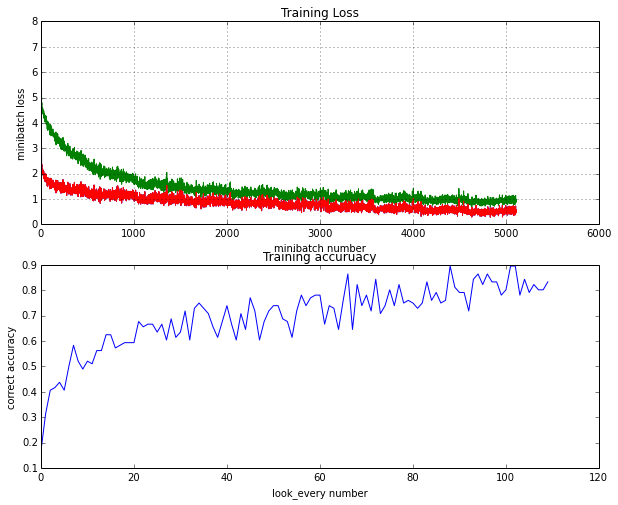

best_val_acc: 0.680000  , test set accuracy: 0.663400  


(0.68000007, 0.66339999999999999)

In [26]:
class configs:
    
    data_size = 49000

    epochs = 10
    batch_size = 96 
    hidden_size = 400
    verbose = True
    
    initial_learining_rate = 2.683e-4
    decay_steps = data_size // batch_size
    
    update_rule = 'adam'
    
    learning_rate_decay = 0.95
    stddev = 1.38950e-2
    reg = 0.005
    
    print_every = 50
    model_path_name = "./models/conv_models.ckpt"
    

run_training(configs, True)